# Practice with the Tensorflow 2 Functional API. 

> In this post, it will demonstrate how to build models with the Functional syntax. You'll build one using the Sequential API and see how you can do the same with the Functional API. Both will arrive at the same architecture and you can train and evaluate it as usual. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- hide: false
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearning.AI]
- image: 

## Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFont, ImageDraw
import random

## Part 1 - Comparing Functional API with Sequential API

### Prepare the Data

We will use mnist dataset for the check.

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

### Sequential API

Here is how we use the `Sequential()` class to build a model.

In [3]:
def build_model_with_sequential():
    # instantiate a Sequential class and linearly stack the layers of your model
    seq_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    return seq_model

### Functional API

And here is how you build the same model above with the functional syntax.

In [4]:
def build_model_wtih_functional():
    # instantiate the input Tensor
    input_layer = tf.keras.Input(shape=(28, 28))
    
    # stack the layers using the syntax: new_layer()(previous_layer)
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    first_dense = tf.keras.layers.Dense(128, activation=tf.nn.relu)(flatten_layer)
    output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(first_dense)
    
    # declare inputs and outputs
    func_model = Model(inputs=input_layer, outputs=output_layer)
    return func_model

### Build the model and visualize the model graph

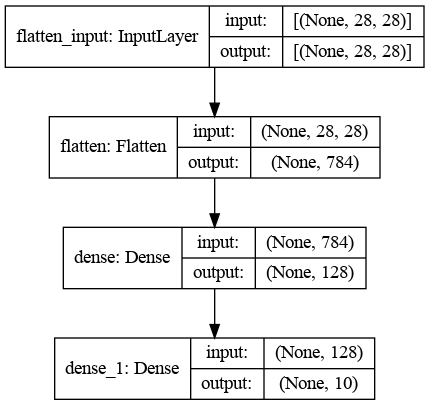

In [5]:
model = build_model_with_sequential()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/sequential_model.png')

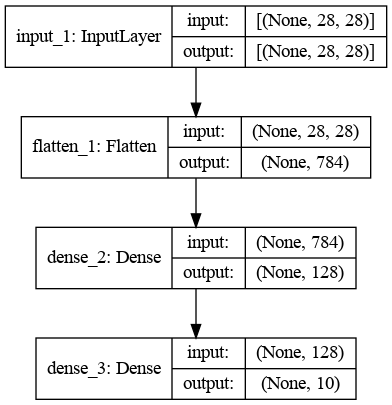

In [6]:
model = build_model_wtih_functional()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/functional_model.png')

You can see that both model has same architecture.

### Training the model

Regardless if you built it with the Sequential or Functional API, you'll follow the same steps when training and evaluating your model.

In [7]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 732us/step - loss: 0.4303 - accuracy: 0.8805
Epoch 2/5
1875/1875 [==============================] - 1s 720us/step - loss: 0.1211 - accuracy: 0.9641
Epoch 3/5
1875/1875 [==============================] - 1s 703us/step - loss: 0.0771 - accuracy: 0.9765
Epoch 4/5
1875/1875 [==============================] - 1s 704us/step - loss: 0.0621 - accuracy: 0.9803
Epoch 5/5
1875/1875 [==============================] - 1s 687us/step - loss: 0.0424 - accuracy: 0.9865


In [8]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 703us/step - loss: 0.0861 - accuracy: 0.9714


[0.0861198902130127, 0.9714000225067139]

## Part 2 - Build a Multi-output Model

In this section, In this post, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load.

### Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [9]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])

def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

### Prepare the Data

We download the dataset and format it for training.

In [30]:
# Specify data URI
URI = './dataset/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df.dropna(axis=1, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the train and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

### Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [31]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,5,0.40,1,32.53,33.04
1,0.69,735.0,294.0,220.50,3.5,5,0.10,5,11.16,14.39
2,0.98,514.5,294.0,110.25,7.0,5,0.25,2,28.60,30.02
3,0.86,588.0,294.0,147.00,7.0,5,0.25,5,29.39,33.47
4,0.79,637.0,343.0,147.00,7.0,2,0.40,3,41.26,46.44


In [32]:
# define model layers
input_layer = Input(shape=(len(train.columns), ))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

In [33]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          1152        input_4[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          16512       dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 64)           8256        dense_11[0][0]                   
____________________________________________________________________________________________

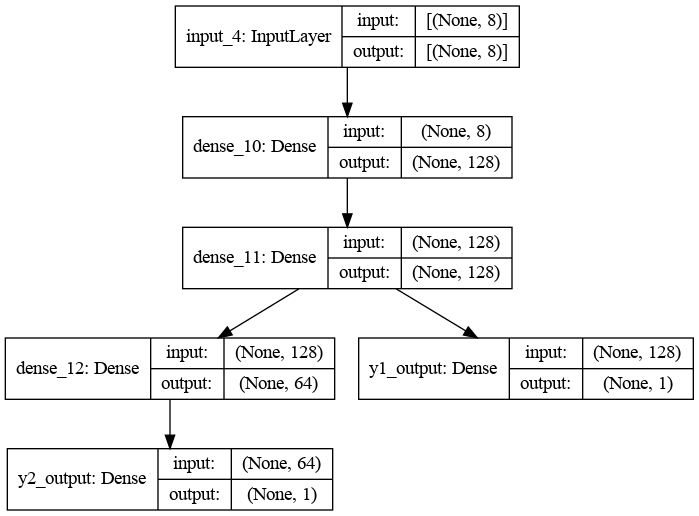

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/multi_output_model.png')

### Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [35]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={
                  'y1_output':'mse',
                  'y2_output':'mse'
              },
             metrics={
                 'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                 'y2_output':tf.keras.metrics.RootMeanSquaredError()
             })

### Train the Model

In [ ]:
# train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y), verbose=0)

### Evaluate the Model and Plot Metrics

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')

In [ ]:
plot_diff(test_Y[1], Y_pred[1], title='Y2')

In [ ]:
plot_metrics(history, metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)

In [ ]:
plot_metrics(history, metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)